Exploratory Data Analysis

01. Load data

In [18]:
import pandas as pd

cashrequest_df = pd.read_csv("project_dataset/cashreq-clean.csv")
fees_and_cohorts_df = pd.read_csv("project_dataset/fees-with-cohort-and-user-id-clean.csv")

C:\Users\edumc\AppData\Local\Temp\ipykernel_17708\1667466518.py:4: DtypeWarning: Columns (29,30,31,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  fees_and_cohorts_df = pd.read_csv("project_dataset/fees-with-cohort-and-user-id-clean.csv")


In [ ]:
# Edu: EXTRA metric 4:
# relacion volumen de cash reques contra reco creation y reco resolve. Los que piden poco han tenido incidencias más largas (recovery)


# "We analyzed the relationship between the volume of cash requests and the creation and resolution of recovery cases.
# Hypothesis to test: Users with fewer requests tend to experience longer recovery times.
#New Metric: XXXX
# Columns: 



In [ ]:
#Function for showing data with seaborn:
# sns.set_theme(style="whitegrid")
# plt.figure(figsize=(10, 6))
# sns.countplot(data=incident_feed, x='cohort', palette='viridis')  # <- Notice y='Country' instead of x
# incident_feed.pivot.plot(kind='bar', stacked=True, colormap='viridis')
# plt.title('Fee Incidents by Cohort')
# plt.xlabel('Cohort')
# plt.ylabel('Fee Incidents')
# plt.xticks(rotation=45, ha='right')  # Rotate x labels for better visibility
# plt.tight_layout()
# plt.show()
    
    

02. Checks on Timestamnps data types and drop of incomplete records from the scope of this analysis

In [19]:
#Hypothesis Test: "Users with fewer requests are prone to experience longer recovery times."
    
#Drop rows with null timestamps
fees_and_cohorts_df['reco_creation'] = pd.to_datetime(fees_and_cohorts_df['reco_creation'], errors='coerce')
fees_and_cohorts_df['reco_last_update'] = pd.to_datetime(fees_and_cohorts_df['reco_last_update'], errors='coerce')

# Only keep completed recoveries for clear duration measurement
fees_and_cohorts_df_completed = fees_and_cohorts_df[fees_and_cohorts_df['recovery_status'] == 'completed'].copy()

# Drop incomplete data
fees_and_cohorts_df_completed.dropna(subset=['reco_creation', 'reco_last_update', 'total_amount', 'user_id'], inplace=True)



3. Calculate Recovery Duration

In [20]:
#For each completed recovery case:
# recovery_duration = reco_last_update - reco_creation (in days)

fees_and_cohorts_df_completed['recovery_duration_days'] = (fees_and_cohorts_df_completed['reco_last_update'] - fees_and_cohorts_df_completed['reco_creation']).dt.days


Validating results

In [21]:
fees_and_cohorts_df_completed['recovery_duration_days'].sample(10)

9207      56
9173      52
16711      0
7122      62
13106     34
18370    128
14473     28
2518       0
17970      0
901        2
Name: recovery_duration_days, dtype: int64

In [22]:
fees_and_cohorts_df_completed['recovery_duration_days'].describe()


count    4945.000000
mean       23.126997
std        31.929807
min         0.000000
25%         1.000000
50%        12.000000
75%        27.000000
max       202.000000
Name: recovery_duration_days, dtype: float64

4. Group by user_id

    Count number of requests (rows) per user
    Average recovery duration per user

In [25]:
agg_fees_and_cohorts_df_completed = fees_and_cohorts_df_completed.groupby('user_id').agg(num_requests=('cash_request_id', 'count'),avg_recovery_duration=('recovery_duration_days', 'mean')).reset_index()


In [29]:
#results validation:
agg_fees_and_cohorts_df_completed.describe()


,user_id,num_requests,avg_recovery_duration
count,2021.000000,2021.000000,2021.000000
mean,38429.328550,2.446809,18.612790
std,28228.605533,2.116125,26.029534
min,72.000000,1.000000,0.000000
25%,15219.000000,1.000000,1.000000
50%,31026.000000,2.000000,11.000000
75%,56899.000000,3.000000,22.000000
max,103496.000000,28.000000,202.000000


5. Correlation Analysis

Use statistical correlation metrics like:

    . Pearson correlation
    . Spearman correlation (in case of non-linear monotonic relationship)

In [ ]:
from scipy.stats import pearsonr, spearmanr

pearson_corr, _ = pearsonr(agg_fees_and_cohorts_df_completed['num_requests'], agg_fees_and_cohorts_df_completed['avg_recovery_duration'])
spearman_corr, _ = spearmanr(agg_fees_and_cohorts_df_completed['num_requests'], agg_fees_and_cohorts_df_completed['avg_recovery_duration'])


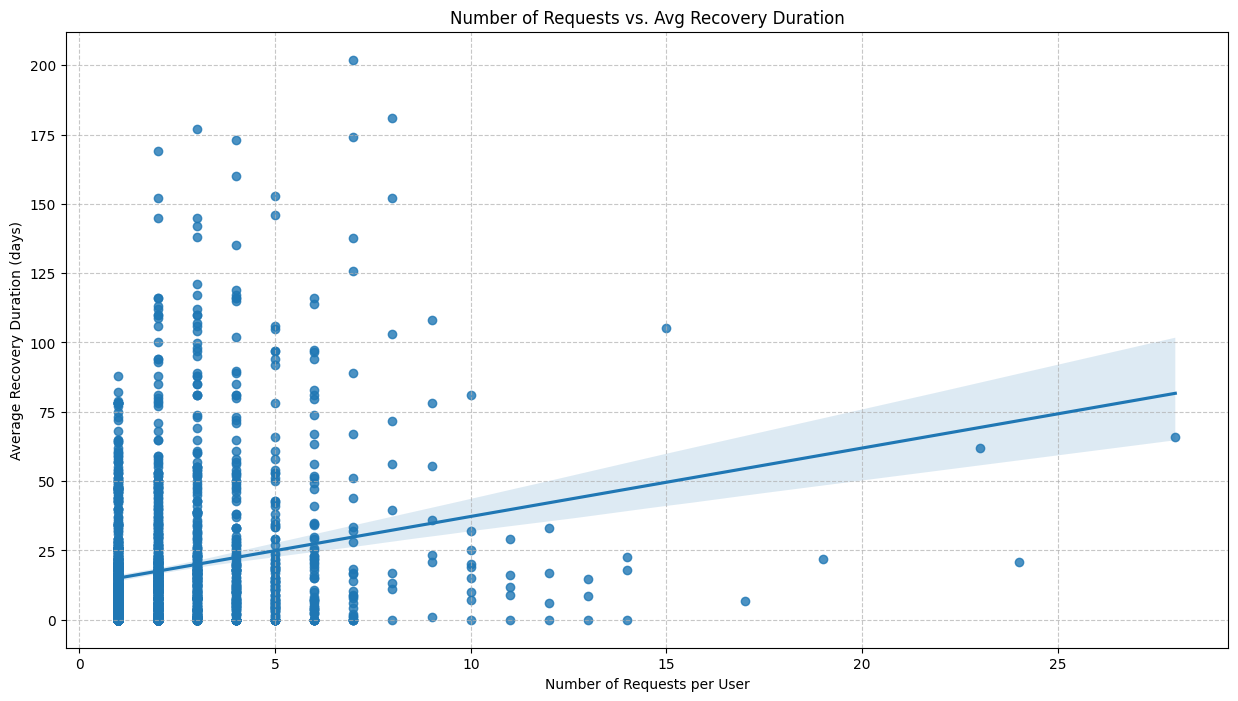

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))
plt.grid(True, linestyle='--', alpha=0.7)
sns.regplot(x='num_requests', y='avg_recovery_duration', data=agg_fees_and_cohorts_df_completed)
plt.title("Number of Requests vs. Avg Recovery Duration")
plt.xlabel("Number of Requests per User")
plt.ylabel("Average Recovery Duration (days)")
plt.show()


Conclussions:

1. For users with few requests (e.g., 1 to 5), there's a much wider spread in recovery durations — including some very high values (100–200 days).
2. For users with many requests, recovery durations are more tightly clustered around lower values.


Higher variability and higher potential for extreme durations happen among users with fewer requests.
This could mean:

    There may be subgroups worth isolating (e.g., segmenting by number of requests).
    A non-linear relationship or heteroscedasticity is present — which would break assumptions of linear regression.

Next Steps:

    1. Plot a violin plot or box plot by buckets of request count:
        Helps visualize distributions per group (e.g., 1-2, 3-5, 6-10, etc.)

    2. Use log transformation or quantile analysis:
        To better capture non-linear or skewed patterns.

    3. Check variance across request bins:
        Validate if fewer-request users truly have more erratic durations.

    4. Use non-parametric tests like Kruskal-Wallis:
        To compare medians across bins without assuming normality.